## 7-4. Transfer Learning의 적용

- ResNet50 transfer learning 코드로 살펴보기

### 학습 준비
학습 진행을 위해서 데이터를 준비해주세요!

- 실습에 필요한 라이브러리를 불러옵니다.
- 각각의 클래스에 해당하는 이미지의 개수를 알아보기 위해, 실습 데이터의 클래스마다 파일 경로를 변수로 정의합니다.

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
train_dir='data/cifar_10_small/train'
test_dir='data/cifar_10_small/test'

train_aeroplane_dir= os.path.join(train_dir,'aeroplane')
train_bird_dir=os.path.join(train_dir,'bird')
train_car_dir= os.path.join(train_dir,'car')
train_cat_dir=os.path.join(train_dir,'cat')

test_aeroplane_dir= os.path.join(test_dir,'aeroplane')
test_bird_dir=os.path.join(test_dir,'bird')
test_car_dir= os.path.join(test_dir,'car')
test_cat_dir=os.path.join(test_dir,'cat')

- 각각의 디렉토리에 포함된 파일의 개수를 출력하여 훈련/테스트 데이터셋의 이미지 개수를 알아냅니다.

In [4]:
print('훈련용 aeroplane 이미지 전체 개수:', len(os.listdir(train_aeroplane_dir)))
print('훈련용 bird 이미지 전체 개수:', len(os.listdir(train_bird_dir)))
print('훈련용 car 이미지 전체 개수:', len(os.listdir(train_car_dir)))
print('훈련용 cat 이미지 전체 개수:', len(os.listdir(train_cat_dir)))

print('테스트용 aeroplane 이미지 전체 개수:', len(os.listdir(test_aeroplane_dir)))
print('테스트용 bird 이미지 전체 개수:', len(os.listdir(test_bird_dir)))
print('테스트용 car 이미지 전체 개수:', len(os.listdir(test_car_dir)))
print('테스트용 cat 이미지 전체 개수:', len(os.listdir(test_cat_dir)))

훈련용 aeroplane 이미지 전체 개수: 5000
훈련용 bird 이미지 전체 개수: 5000
훈련용 car 이미지 전체 개수: 5000
훈련용 cat 이미지 전체 개수: 5000
테스트용 aeroplane 이미지 전체 개수: 1000
테스트용 bird 이미지 전체 개수: 1000
테스트용 car 이미지 전체 개수: 1000
테스트용 cat 이미지 전체 개수: 1000


### 데이터 파이프 라인 생성하기
데이터 파이프 라인은 본 과정의 핵심이 아니기 때문에 이런 예제가 있다는 정도만 받으들이시면 됩니다. 😊

- 데이터를 디렉토리로부터 불러올 때 한번에 가져올 데이터의 수인 batch size를 설정하고, data generator를 생성하여 데이터를 모델에 넣을 수 있도록 합니다.
- 우선 ImageDataGenerator 객체를 생성하여 데이터 파이프 라인을 만듭니다. train dataset의 generator에는 augmentation이 포함되고, test dataset의 generator는 원본 상태를 유지하고 rescaling만 적용합니다.


In [5]:
### data 파이프 라인 생성

# 데이터를 디렉토리로부터 불러올 때, 한번에 가져올 데이터의 수
batch_size=20

# Training 데이터의 augmentation 파이프 라인 만들기
augmentation_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255,  # 모든 데이터의 값을 1/255로 스케일 조정
                                    rotation_range=40,  # 0~40도 사이로 이미지 회전
                                    width_shift_range=0.2,  # 전체 가로 길이를 기준으로 0.2 비율까지 가로로 이동
                                    height_shift_range=0.2,   # 전체 세로 길이를 기준으로 0.2 비율까지 가로로 이동
                                    shear_range=0.2,  # 0.2 라디안 정도까지 이미지를 기울이기
                                    zoom_range=0.2, # 확대와 축소의 범위 [1-0.2 ~ 1+0.2 ]
                                    horizontal_flip=True,)  # 수평 기준 플립을 할 지, 하지 않을 지를 결정

# Test 데이터의 augmentation 파이프 라인 만들기
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

- Augmentation 파이프라인을 기준으로 디렉토리로부터 데이터를 불러오는 모듈을 만듭니다. train/test dataset의 경로와 이미지 크기 등을 지정하여 train_generator와 test_generator 생성하면 됩니다.

In [6]:
# Augmentation 파이프라인을 기준으로 디렉토리로부터 데이터를 불러 오는 모듈 만들기
train_generator = augmentation_train_datagen.flow_from_directory(
        directory=train_dir, #  어느 디렉터리에서 이미지 데이터를 가져올 것인가?
        target_size=(150, 150), # 모든 이미지를 150 × 150 크기로 바꿉니다
        batch_size=batch_size, # 디렉토리에서 batch size만큼의 이미지를 가져옵니다.
        interpolation='bilinear',  # resize를 할 때, interpolatrion 기법을 결정합니다.
        color_mode ='rgb',
        shuffle='True', # 이미지를 셔플링할 지 하지 않을 지를 결정.
        class_mode='categorical') # multiclass의 경우이므로 class mode는 categorical

print(train_generator.class_indices)

Found 20000 images belonging to 4 classes.
{'aeroplane': 0, 'bird': 1, 'car': 2, 'cat': 3}


In [7]:
# Test 데이터 또한 디렉토리로부터 이미지를 불러오는 파이프라인을 완성해야 한다.
test_generator = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        shuffle='True',
        interpolation='bilinear',  ## resize시 interpolatrion 기법
        color_mode='rgb',
        class_mode='categorical') #categorical

Found 4000 images belonging to 4 classes.


- Train data의 파이프 라인이 batch size만큼의 데이터를 잘 불러오는 지 확인해 봅시다.

In [8]:
for data_batch, labels_batch in train_generator: 
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20, 4)


### 모델 불러오기

- 바탕이 되는 Pretrained Model(ResNet50)을 불러오고 모델의 구조를 살펴봅시다.

In [9]:
## back bone
conv_base=tf.keras.applications.ResNet50(weights='imagenet',include_top=False)
conv_base.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, None, None, 3)     │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, None, None, 64)    │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, None, None, 64)    │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, None, None, 64)    │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, None, None, 64)    │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, None, None, 64)    │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, None, None, 64)    │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, None, None, 64)    │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, None, None, 64)    │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, None, None, 64)    │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, None, None, 256)   │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, None, None, 256)   │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

### 최종 모델 구성

- input layer와 ResNet50 backbone, fully-connected layer를 연결하여 transfer learning 모델을 만듭니다.

In [10]:
# 최종 모델 구성하기
input_layer = tf.keras.layers.Input(shape=(150,150,3))
x = conv_base(input_layer) # 위에서 불러온 pretrained model을 활용하기
# 불러온 conv_base 모델의 최종 결과물은 Conv2D 연산의 feature map과 동일
# 따라서 최종적인 Multiclass classfication을 하기 위해서는 Flatten을 해야 한다.
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
out_layer = tf.keras.layers.Dense(4, activation='softmax')(x)

- conv_base는 freeze 시킴으로써 이미 학습된 파라미터 값을 그대로 사용합니다.

In [11]:
conv_base.trainable = False

- 만들어진 모델의 구조를 살펴봅시다.

In [12]:
model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,804,676 (189.99 MB)

 Trainable params: 26,216,964 (100.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

- loss function과 optimizer, metric을 설정하고 모델을 컴파일합니다.

In [13]:
loss_function=tf.keras.losses.categorical_crossentropy 
optimize=tf.keras.optimizers.Adam(learning_rate=0.0001)
metric=tf.keras.metrics.categorical_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

- data generator는 입력 데이터와 타겟(라벨)의 batch를 끝없이 반환합니다.
- batch가 끝없이 생성되기 때문에, 한 번의 epoch에 generator로부터 얼마나 많은 샘플을 뽑을지 모델에 전달해야 합니다.
- 만약 batch_size=20이고 steps_per_epoch=100일 경우 (데이터, 라벨)의 쌍 20개가 생성되고, 크기가 20인 batch 데이터를 100번 학습하면 1 epoch이 완료됩니다. - 단, 크기 20의 batch 데이터는 매번 랜덤으로 생성됩니다.

In [16]:
history = model.fit( 
      train_generator,
      #steps_per_epoch=(len(os.listdir(train_aeroplane_dir)) + len(os.listdir(train_bird_dir)) + len(os.listdir(train_car_dir)) + len(os.listdir(train_cat_dir))) // batch_size,
      steps_per_epoch=100,
      epochs=20,
      validation_data=test_generator,
      validation_freq=1)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 900ms/step - categorical_accuracy: 0.4318 - loss: 1.2199 - val_categorical_accuracy: 0.4428 - val_loss: 1.1597
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 997ms/step - categorical_accuracy: 0.4456 - loss: 1.2356 - val_categorical_accuracy: 0.4560 - val_loss: 1.1770
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - categorical_accuracy: 0.4286 - loss: 1.2330 - val_categorical_accuracy: 0.5623 - val_loss: 1.0563
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 994ms/step - categorical_accuracy: 0.4252 - loss: 1.2362 - val_categorical_accuracy: 0.5270 - val_loss: 1.0991
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 98s 986ms/step - categorical_accuracy: 0.4228 - loss: 1.2494 - val_categorical_accuracy: 0.4825 - val_loss: 1.1383
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 961ms/step - categorical_accuracy: 0.4158 - loss: 1.2323 - val_categorical_accuracy: 0.4440 - val_loss: 1.2314
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 992ms/step - categorical_acc

- 모델에서 학습한 결과를 hdf5 파일 형식으로 저장하고, 평가 metric들도 따로 저장합니다.

In [17]:
model.save('data/cifar_10_small/multi_classification_augumentation_model.hdf5')

acc = history.history['categorical_accuracy'] 
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

- training set과 validation set의 accuracy, loss를 그래프로 확인해봅시다.

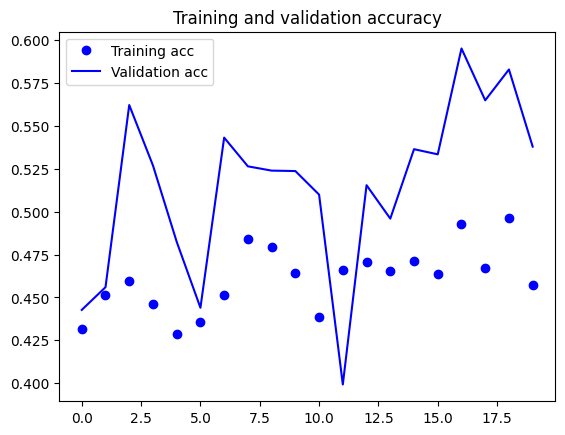

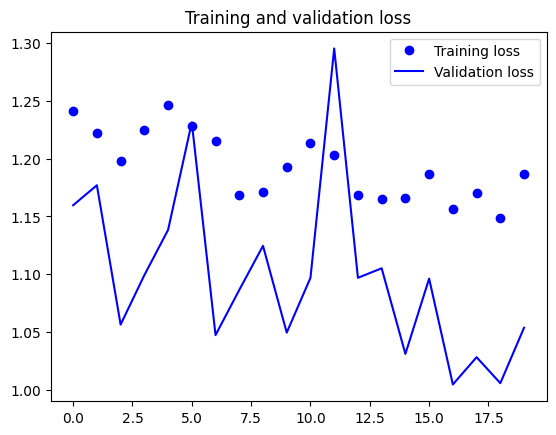

In [18]:
# # 학습한 결과 시각화 
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()